### Naive Bayes Classifier for Digit Recognition (35%)

In [14]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
#from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [15]:


# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
from sklearn.datasets import load_digits
mnist = load_digits()
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)



# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[1540:], Y[1540:]
dev_data, dev_labels = X[1400:1540], Y[1400:1540]
train_data, train_labels = X[:1400], Y[:1400]
mini_train_data, mini_train_labels = X[:200], Y[:200]



data shape:  (1797, 64)
label shape: (1797,)


### A. Create a 10x10 grid to visualize 10 examples of each digit.

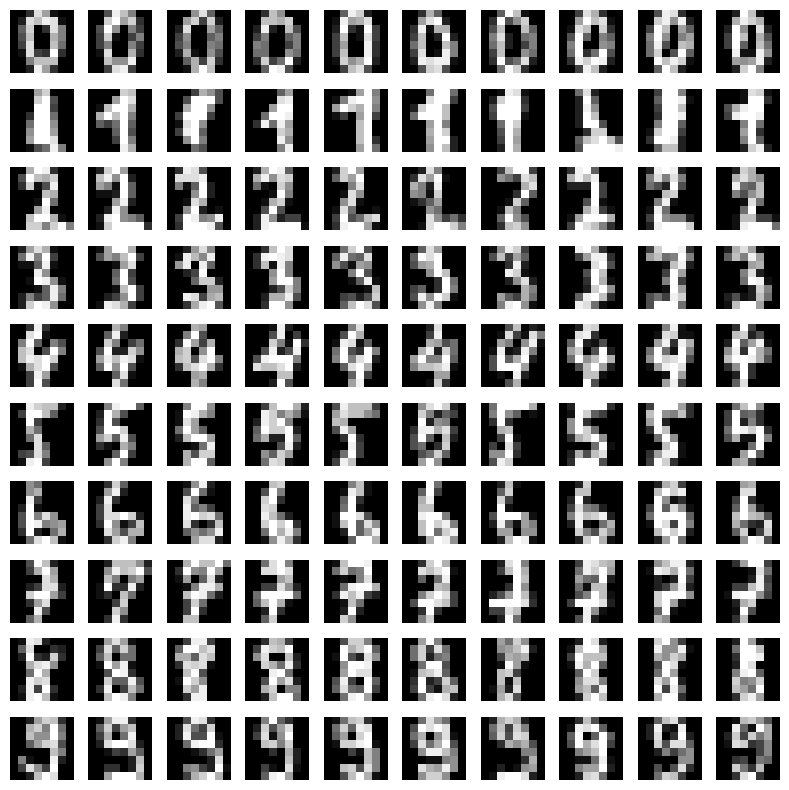

In [70]:
import matplotlib.pyplot as plt

# Create a figure for the plot
fig, axes = plt.subplots(10, 10, figsize=(8, 8))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Extract 10 samples for each digit from 0 to 9
examples = []
for digit in range(10):
    digit_examples = np.where(Y == digit)[0][:10]  # Get indices of first 10 occurrences
    examples.extend(digit_examples)

# Plot each digit on the grid
for i, idx in enumerate(examples):
    axes[i].imshow(X[idx].reshape(8, 8), cmap='gray')
    axes[i].axis('off')  # Turn off the axis

# Show the plot
plt.tight_layout()
plt.show()


### B.  Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?
### Note, the answers may vary depending on what thresholds you set.

In [78]:
import numpy as np
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.preprocessing import Binarizer
from sklearn.metrics import accuracy_score

binarizer = Binarizer(threshold=0.02)
X_binarized = binarizer.fit_transform(train_data)
dev_data_binarized = binarizer.transform(dev_data)

# Fit Bernoulli Naive Bayes model
bernoulli_nb = BernoulliNB()
bernoulli_nb.fit(X_binarized, train_labels)

# Predict on dev data and calculate accuracy
y_pred_dev_bernoulli = bernoulli_nb.predict(dev_data_binarized)
accuracy_dev_bernoulli = accuracy_score(dev_labels, y_pred_dev_bernoulli)

print(f"BernoulliNB accuracy on binarized data: {accuracy_dev_bernoulli * 100:.2f}%")

BernoulliNB accuracy on binarized data: 90.71%


In [69]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Define a function to categorize pixel values into custom thresholds
def categorize_pixel_values(X, thresholds):
    return np.digitize(X, thresholds) - 1  # Subtract 1 to get categories in the range [0, num_bins - 1]

# Create custom thresholds based on data quantiles
thresholds = np.quantile(train_data, [0.30, 0.65, 0.88])  # Based on quartiles

# Categorize the pixel values
X_categorized = categorize_pixel_values(train_data, thresholds)
dev_data_categorized = categorize_pixel_values(dev_data, thresholds)

# Fit and evaluate MultinomialNB
multinomial_nb.fit(X_categorized, train_labels)
y_pred_dev_multinomial = multinomial_nb.predict(dev_data_categorized)
accuracy_dev_multinomial = accuracy_score(dev_labels, y_pred_dev_multinomial)

print(f"MultinomialNB accuracy with quantile thresholds: {accuracy_dev_multinomial * 100:.2f}%")

MultinomialNB accuracy with quantile thresholds: 87.86%


# Results

BernoulliNB (90.71%) outperforms MultinomialNB (87.86%), suggesting that binarizing pixel values is more effective for this dataset than mapping them into multiple categories. The sharp contrast between foreground (digits) and background seems to be the most important feature, and the simplicity of binary features gives BernoulliNB an edge.

MultinomialNB (87.86%) still performs well but does not surpass BernoulliNB. The multi-class mapping of pixel intensities to white, gray, and black likely introduces some unnecessary complexity, which doesn't add significant value over binary features in this case.

### C. Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Could you explain why?

In [71]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Train Gaussian Naive Bayes model
gaussian_nb = GaussianNB()
gaussian_nb.fit(train_data, train_labels)

# Predict on dev data
y_pred_dev_gaussian = gaussian_nb.predict(dev_data)

# Calculate accuracy
accuracy_dev_gaussian = accuracy_score(dev_labels, y_pred_dev_gaussian)

print(f"GaussianNB accuracy on dev data: {accuracy_dev_gaussian * 100:.2f}%")

GaussianNB accuracy on dev data: 84.29%


# Results

Intended for continuous real-valued data: Gaussian Naive Bayes assumes that the features for each class are normally (Gaussian) distributed. 

Violation of the Gaussian assumption:The pixel intensity distribution is not Gaussian. For most of the image, pixel intensities are clustered near two values—either low values (background) or high values (foreground, digit). This bimodal or even multimodal distribution makes it difficult for GaussianNB to model accurately.

Lack of spatial information: GaussianNB treats each pixel independently, without considering that neighboring pixels in an image are highly correlated. The model ends up losing important contextual information that could help in recognizing digits.

Better suited for other types of data: GaussianNB works well when features are continuous and normally distributed (e.g., in some scientific data, sensor readings, or financial data). It just isn't well-suited for image data, especially low-resolution images like digit recognition where pixel correlation matters a lot.